# Parameters

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import os

num_classes = 6
batch_size = 32
dataset_tag = 'VPC'                 # was 'Karolinska'

graph_type = 'heterogeneous'        # ['10','20','40','heterogeneous','homogeneous']
fold = 'fold1'
iterate = 1

model_name = '_MS_RGCN'             # choose your variant suffix

# Where the processed graphs live (from the graph-building step)
graphs_root = '../feature_extractor_6class/256_VPC_embeddings'  # base dir used when saving graphs
data_path = f'{graphs_root}/{fold}/processed/'   # contains <core>_{graph_type}.pt files

# Where to save the trained graph model
model_dir = f'../models/model_VPC/graph/{fold}'
os.makedirs(model_dir, exist_ok=True)
model_path = f'{model_dir}/model_{graph_type}{model_name}_{iterate}.pth'

print("Saving to:", model_path)
print("Loading graphs from:", data_path)


Saving to: ../models/model_VPC/graph/fold1/model_heterogeneous_MS_RGCN_1.pth
Loading graphs from: ../feature_extractor_6class/256_VPC_embeddings/fold1/processed/


# Import

In [3]:
# import for RGATConv
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter, ReLU, Sequential
from torch_scatter import scatter_add
from torch_sparse import SparseTensor

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import glorot, ones, zeros
from torch_geometric.typing import Adj, OptTensor, Size
from torch_geometric.utils import softmax

In [4]:
# import dgl
# from dgl.data import DGLDataset
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleDict
from torch_geometric.nn import GCNConv, RGCNConv, global_mean_pool, to_hetero, GATConv, SAGPooling, BatchNorm, LayerNorm, AGNNConv, ResGatedGraphConv, SGConv, GINConv #, InstanceNorm, GraphNorm, PairNorm
import os
import networkx as nx # graph visualization
import pickle
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
import time
# from pyg_class.RGAT_Conv import RGATConv

# Utils

In [5]:
# convert a dict of tensors to float (leave non-tensors as is)
def dict_to_float(orig):
    new = {}
    for k, v in orig.items():
        new[k] = v.float() if isinstance(v, torch.Tensor) else v
    return new

def get_edge_index_type(data, device=None):
    """
    Flattens a HeteroData's edge_index_dict into a single edge_index and an edge_type vector.
    - Works on both heterogeneous and homogeneous graphs.
    - Keeps correct dtype (long) and device.
    """
    if hasattr(data, 'edge_index_dict'):  # heterogeneous
        edge_index_list = []
        edge_type_list = []
        for i, et in enumerate(data.edge_types):  # et is a (src, rel, dst) tuple
            ei = data.edge_index_dict[et]        # [2, E_et]
            edge_index_list.append(ei)
            edge_type_list.append(torch.full((ei.size(1),), i, dtype=torch.long, device=ei.device))
        edge_index = torch.cat(edge_index_list, dim=1) if edge_index_list else torch.empty((2,0), dtype=torch.long)
        edge_type  = torch.cat(edge_type_list,  dim=0) if edge_type_list  else torch.empty((0,),   dtype=torch.long)
    else:  # homogeneous
        edge_index = data.edge_index
        edge_type  = torch.zeros(edge_index.size(1), dtype=torch.long, device=edge_index.device)

    if device is not None:
        edge_index = edge_index.to(device)
        edge_type  = edge_type.to(device)
    return edge_index, edge_type

def quadratic_weighted_kappa(y_hat, y):
    # ensure numpy arrays for sklearn
    if isinstance(y_hat, torch.Tensor): y_hat = y_hat.detach().cpu().numpy()
    if isinstance(y, torch.Tensor):     y     = y.detach().cpu().numpy()
    return cohen_kappa_score(y_hat, y, weights="quadratic")

def safe_macro_auc(y_true_np, probs_np, num_classes):
    """
    Robust macro AUC for multiclass with possibly-missing classes in y_true.
    y_true_np: shape [N], ints
    probs_np:  shape [N, C]
    """
    classes_present = np.unique(y_true_np)
    if len(classes_present) <= 1:
        return float('nan')  # AUC undefined with <2 classes

    # Fast path: slice columns to present classes and pass labels
    try:
        return roc_auc_score(
            y_true_np,
            probs_np[:, classes_present],
            labels=classes_present,
            average='macro',
            multi_class='ovr'
        )
    except Exception:
        # Fallback: one-vs-rest per present class, then average
        aucs = []
        for c in classes_present:
            y_bin = (y_true_np == c).astype(int)
            if y_bin.min() == y_bin.max():  # all 0 or all 1 -> undefined
                continue
            aucs.append(roc_auc_score(y_bin, probs_np[:, c]))
        return float(np.mean(aucs)) if aucs else float('nan')


class SaveBestModel:
    """
    Save the best model by validation accuracy (or any scalar you pass as current_acc).
    """
    def __init__(self):
        self.best_acc = 0.0
        
    def __call__(self, current_acc, epoch, model, optimizer):
        if current_acc > self.best_acc:
            self.best_acc = float(current_acc)
            print(f"\nBest validation ACC so far: {self.best_acc:.4f}")
            print(f"Saving best model at epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': self.best_acc
            }, model_path)

save_model = SaveBestModel()


# PYG Utils by Roozbeh

In [6]:
class GlobalAttentionPooling(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.att = torch.nn.MultiheadAttention(embed_dim, num_heads, dropout=0.0, batch_first=True)

    def forward(self, x, batch):
        # x: [N, D], batch: [N] with graph IDs per node (0..B-1)
        device = x.device
        D = x.size(-1)
        B = int(batch.max().item()) + 1 if x.numel() > 0 else 0

        # preallocate on the same device/dtype as x
        output = x.new_zeros((B, D))

        for b in range(B):
            mask = (batch == b)
            xb = x[mask]                    # [Nb, D]
            if xb.numel() == 0:
                continue
            xb = xb.unsqueeze(0)            # [1, Nb, D] for batch_first=True
            attn_output, _ = self.att(xb, xb, xb)  # [1, Nb, D]
            output[b] = attn_output.mean(dim=1).squeeze(0)

        return output


# Dataset

In [7]:
class VPCDataset(Dataset):
    def __init__(self, root, fold, magnification, train,
                 transform=None, pre_transform=None, pre_filter=None):
        """
        root: can be either '<graphs_root>/' or '<graphs_root>/<fold>/processed/'
        fold: 'fold1'..'fold5' (4/5 remap to 1/2 per original logic)
        magnification: suffix in filename (e.g. 'heterogeneous', 'homogeneous', '10', '20', '40')
        train: bool (True -> first 80%, False -> last 20%) for folds 1-3
        """
        self.fold = fold
        self.fold_temp = fold
        if fold == 'fold4':
            self.fold_temp = 'fold1'
        elif fold == 'fold5':
            self.fold_temp = 'fold2'

        self.magnification = magnification
        self.train = train

        # Normalize roots so PyG's base class doesn't try to 'download' or 'process'
        root = os.path.normpath(root)
        if os.path.basename(root) == "processed":
            # root is already .../<fold>/processed
            self._base_root = os.path.dirname(root)   # .../<fold>
            self._processed_root = root               # .../<fold>/processed
        else:
            # root is the graphs_root base; we point to this fold's subdir
            self._base_root = os.path.join(root, self.fold_temp)      # .../<fold>
            self._processed_root = os.path.join(self._base_root, "processed")  # .../<fold>/processed

        # Ensure dirs exist to stop PyG from calling download/process
        os.makedirs(self._processed_root, exist_ok=True)
        os.makedirs(self.raw_dir, exist_ok=True)

        super().__init__(self._base_root, transform, pre_transform, pre_filter)

    # ---- Make PyG look in the right places ----
    @property
    def raw_dir(self):
        return os.path.join(self._base_root, "raw")

    @property
    def processed_dir(self):
        return self._processed_root

    @property
    def raw_file_names(self):
        # No real raw files; return a harmless placeholder
        return ['_graphs_ready']

    @property
    def processed_file_names(self):
        if not os.path.isdir(self.processed_dir):
            return []
        # Match files that end with '_<magnification>.pt'
        graphs = [f for f in os.listdir(self.processed_dir)
                  if f.endswith(f'_{self.magnification}.pt')]
        graphs.sort()

        if self.fold in ['fold1', 'fold2', 'fold3']:
            split = len(graphs) * 4 // 5
            return graphs[:split] if self.train else graphs[split:]

        # folds 4/5 keep your original inverse split style
        split = len(graphs) // 5
        return graphs[split:] if self.train else graphs[:split]

    # ---- Disable PyG's download/process (we already have saved graphs) ----
    def download(self):
        # Do nothing; required to avoid assert
        return

    def process(self):
        # Do nothing; graphs already processed & saved to disk
        return

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        fname = self.processed_file_names[idx]
        data = torch.load(os.path.join(self.processed_dir, fname))
        # keep original return: (data, first 16 chars of core name)
        return data, fname[:16]


## Zurich dataset
class ZurichDataset(Dataset):
    def __init__(self, root, slides, fold, magnification,
                 transform=None, pre_transform=None, pre_filter=None):
        """
        root: '<graphs_root>/' or '<graphs_root>/<fold>/processed/'
        slides: list/iterable of slide names like ['slide001', ...]
        magnification: suffix to match ('heterogeneous', '40', etc.)
        """
        self.fold = fold
        self.magnification = magnification
        self.slides = set(slides)

        root = os.path.normpath(root)
        if os.path.basename(root) == "processed":
            self._base_root = os.path.dirname(root)
            self._processed_root = root
        else:
            self._base_root = os.path.join(root, fold)
            self._processed_root = os.path.join(self._base_root, "processed")

        os.makedirs(self._processed_root, exist_ok=True)
        os.makedirs(self.raw_dir, exist_ok=True)

        super().__init__(self._base_root, transform, pre_transform, pre_filter)

    @property
    def raw_dir(self):
        return os.path.join(self._base_root, "raw")

    @property
    def processed_dir(self):
        return self._processed_root

    @property
    def raw_file_names(self):
        return ['_graphs_ready']

    @property
    def processed_file_names(self):
        if not os.path.isdir(self.processed_dir):
            return []
        out = []
        for f in os.listdir(self.processed_dir):
            if not f.endswith(f'_{self.magnification}.pt'):
                continue
            slide_name = f.split('_')[0]  # 'slideXYZ'
            if slide_name in self.slides:
                out.append(f)
        out.sort()
        return out

    def download(self): return
    def process(self): return

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        fname = self.processed_file_names[idx]
        data = torch.load(os.path.join(self.processed_dir, fname))
        return data, fname


In [8]:
dataset_train = VPCDataset(root=data_path, fold=fold, magnification=graph_type, train=True)
dataset_val   = VPCDataset(root=data_path, fold=fold, magnification=graph_type, train=False)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val   = DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)


In [9]:
# --- Compute class weights from TRAIN (graph-level y) ---
num_classes = 6  # ensure this matches your setup
counts = torch.zeros(num_classes, dtype=torch.long)

for data, _ in loader_train:            # batched graphs
    yb = data.y.view(-1).long()         # shape [B], works for homo/hetero
    counts.index_add_(0, yb, torch.ones_like(yb, dtype=torch.long))

# avoid divide-by-zero; normalize to sum=1
weights = 1.0 / (counts.float() + 1e-8)
weights = weights / weights.sum()
print("train weights:", weights)

# --- (Optional) class distribution on VAL ---
counts_val = torch.zeros(num_classes, dtype=torch.long)
for data, _ in loader_val:
    yb = data.y.view(-1).long()
    counts_val.index_add_(0, yb, torch.ones_like(yb, dtype=torch.long))

weights_val = 1.0 / (counts_val.float() + 1e-8)
weights_val = weights_val / weights_val.sum()
print("val weights:", weights_val)

/tmp/ipykernel_547221/3822222312.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, fname))


train weights: tensor([5.0000e-09, 3.3333e-10, 1.8182e-10, 5.0000e-09, 9.4340e-11, 1.0000e+00])
val weights: tensor([1.2500e-09, 1.0000e-09, 3.8462e-10, 5.0000e-01, 1.8519e-10, 5.0000e-01])


# Model

In [10]:
class DeepMIL(nn.Module):
    def __init__(self, feature_size, num_classes):
        super().__init__()
        self.L = feature_size
        self.D = 128
        self.K = 1

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, self.D),
            nn.ReLU(),
            nn.Linear(self.D, num_classes)
            # nn.Sigmoid()
        )

    def forward(self, H):
        # H: [N, L]
        A = self.attention(H)          # [N, K]
        A = A.transpose(1, 0)          # [K, N]
        A = F.softmax(A, dim=1)        # softmax over N
        M = torch.mm(A, H)             # [K, L]  (K=1 -> [1, L])
        Y_prob = self.classifier(M)    # [K, C]  (K=1 -> [1, C])
        return A, Y_prob


class MIL(nn.Module):
    def __init__(self, feature_size, num_classes, MIL_type):
        super().__init__()
        self.num_classes = num_classes
        if MIL_type == 'deep':
            self.model = DeepMIL(feature_size, num_classes)
        else:
            assert False, "MIL_type should be in ['deep', 'var'] set!"

    def forward(self, x, batch):
        """
        x:     [N, D] node embeddings
        batch: [N] graph ids (0..B-1) indicating which graph each node belongs to
        returns: [B, num_classes]
        """
        device = x.device
        B = int(batch.max().item()) + 1 if batch.numel() > 0 else 0
        out = x.new_zeros((B, self.num_classes))  # same dtype/device as x

        for b in range(B):
            xb = x[batch == b]               # [Nb, D]
            if xb.numel() == 0:
                continue
            _, yb = self.model(xb)           # [1, C] when K=1
            out[b] = yb.squeeze(0)           # [C]

        return out

    def prediction(self, x, batch):
        return torch.argmax(self.forward(x, batch), dim=1)


In [11]:
class Rel_GNN(torch.nn.Module):
    """
    Relation-aware GNN using RGCNConv over *all* edge types.
    No hard-coded assumptions about the number of magnifications.
    """
    def __init__(self, feature_size, num_classes):
        super().__init__()
        hidden1 = 256
        hidden2 = 128
        outdim  = 128
        # upper-bound on relation types (must be >= max(edge_type)+1 at runtime).
        # with our builder: up to 7 (3 within-mag + 4 cross dir); keep a safe margin:
        num_rels_max = 12

        self.rgc1 = RGCNConv(feature_size, hidden1, num_rels_max)
        self.rgc2 = RGCNConv(hidden1,    hidden2, num_rels_max)
        self.rgc3 = RGCNConv(hidden2,    outdim,  num_rels_max)

        # MIL head over per-graph node sets; input dim matches last conv dim
        self.pool = MIL(outdim, num_classes, 'deep')

    def forward(self, data):
        # support both HeteroData and Data
        if hasattr(data, 'x'):
            x, batch = data.x.float(), data.batch
        else:
            x, batch = data['0'].x.float(), data['0'].batch

        edge_index, edge_type = get_edge_index_type(data, device=x.device)

        x = F.relu(self.rgc1(x, edge_index, edge_type))
        x = F.relu(self.rgc2(x, edge_index, edge_type))
        x = self.rgc3(x, edge_index, edge_type)

        logits = self.pool(x, batch=batch)  # [B, num_classes]
        return logits

    def prediction(self, data):
        return torch.argmax(self.forward(data), dim=1)


class simple_GNN(torch.nn.Module):
    """
    Simpler GCN baseline (ignores relation types).
    """
    def __init__(self, feature_size, num_classes):
        super().__init__()
        hidden1 = 256
        hidden2 = 128
        outdim  = 128

        self.gcn1 = GCNConv(feature_size, hidden1)
        self.gcn2 = GCNConv(hidden1,      hidden2)
        self.gcn3 = GCNConv(hidden2,      outdim)

        self.norm1 = LayerNorm(hidden1)
        self.norm2 = LayerNorm(hidden2)

        self.pool = MIL(outdim, num_classes, 'deep')

    def forward(self, data):
        if hasattr(data, 'x'):
            x, batch = data.x.float(), data.batch
            edge_index = data.edge_index
        else:
            x, batch = data['0'].x.float(), data['0'].batch
            # flatten hetero to a single edge_index (ignore types)
            edge_index, _ = get_edge_index_type(data, device=x.device)

        x = self.gcn1(x, edge_index)
        x = self.norm1(x, batch); x = F.relu(x)

        x = self.gcn2(x, edge_index)
        x = self.norm2(x, batch); x = F.relu(x)

        x = self.gcn3(x, edge_index)

        logits = self.pool(x, batch=batch)
        return logits

    def prediction(self, data):
        return torch.argmax(self.forward(data), dim=1)


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Peek one sample to get feature size
sample_data, _ = dataset_train[0]  # (Data/HeteroData, name)

# feature size (works for both homo/hetero)
if hasattr(sample_data, 'x'):
    feature_size = sample_data.num_node_features
else:
    # HeteroData: pick node type '0' if present, else first type
    node_type = '0' if ('0' in sample_data.node_types) else sample_data.node_types[0]
    feature_size = sample_data[node_type].num_node_features

# Build model
if graph_type == 'heterogeneous':
    model = Rel_GNN(feature_size, num_classes).to(device)
else:
    model = simple_GNN(feature_size, num_classes).to(device)

# Count trainable params
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", params)
print(model)


Device: cuda
Trainable params: 2377351
Rel_GNN(
  (rgc1): RGCNConv(512, 256, num_relations=12)
  (rgc2): RGCNConv(256, 128, num_relations=12)
  (rgc3): RGCNConv(128, 128, num_relations=12)
  (pool): MIL(
    (model): DeepMIL(
      (attention): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Tanh()
        (2): Linear(in_features=128, out_features=1, bias=True)
      )
      (classifier): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=6, bias=True)
      )
    )
  )
)


/tmp/ipykernel_547221/3822222312.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, fname))


# Training

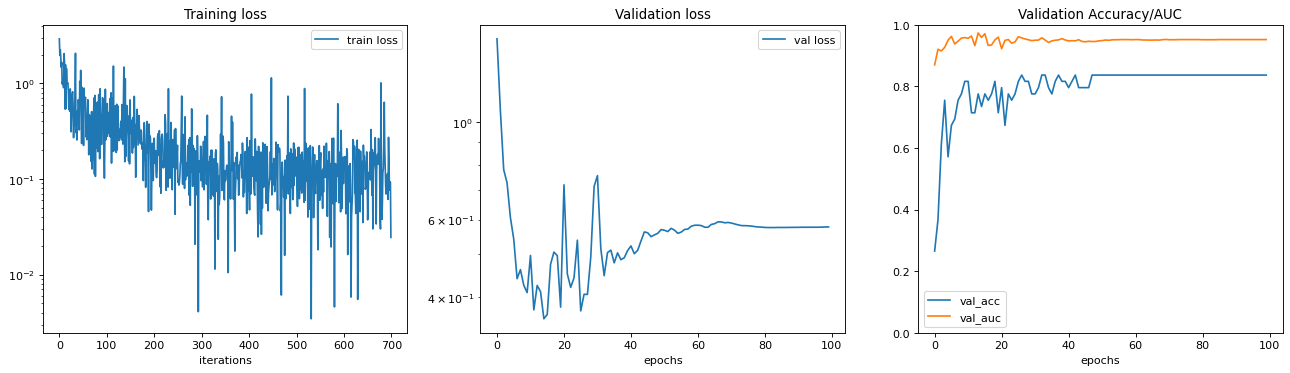

Epoch 100/100 | val_acc=0.8367 | val_auc=0.9519


In [29]:
num_epochs = 100

# prepare plotting (kept)
fig = plt.figure(figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
axes = fig.subplots(1, 3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)

sm = torch.nn.Softmax(dim=1)

# move class weights to device
criterion = torch.nn.CrossEntropyLoss(weight=weights.float().to(device))
# criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device), label_smoothing=0.05)

losses = []
val_losses = []
val_accs = []
val_auc = []

for epoch in range(num_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    for i, (data, core_name) in enumerate(loader_train):
        data = data.to(device)
        y = data.y.view(-1).long().to(device)   # graph-level labels

        logits = model(data)                    # [B, C]
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # ---------------- VALIDATION ----------------
    model.eval()
    n_val = len(dataset_val)
    pred_val = np.zeros(n_val, dtype=np.int64)
    label_np = np.zeros(n_val, dtype=np.int64)
    logits_mat = torch.zeros(n_val, num_classes)  # keep on CPU

    offset = 0
    with torch.no_grad():
        for i, (data, core_name) in enumerate(loader_val):
            # grab labels on CPU BEFORE moving the batch
            y_cpu = data.y.view(-1).long().cpu().numpy()
            bsz = y_cpu.shape[0]

            data = data.to(device)
            logits = model(data).cpu()                 # [B, C] on CPU
            preds  = torch.argmax(logits, dim=1).numpy()

            logits_mat[offset:offset+bsz] = logits
            pred_val[offset:offset+bsz]   = preds
            label_np[offset:offset+bsz]   = y_cpu
            offset += bsz


    # proper CE: logits vs class indices (no one-hot)
    val_loss = F.cross_entropy(logits_mat, torch.from_numpy(label_np), weight=weights_val.float())
    # val_loss = F.cross_entropy(logits_mat, torch.from_numpy(label_np))
    probs = sm(logits_mat).numpy()
    auc = safe_macro_auc(label_np, probs, num_classes)
    val_acc = float((label_np == pred_val).mean())

    val_losses.append(val_loss.item())
    val_accs.append(val_acc)
    val_auc.append(auc)

    # ---------------- PLOT ----------------
    for ax in axes:
        ax.cla()

    axes[0].plot(losses, label='train loss')
    axes[0].set_yscale('log')
    axes[0].set_title('Training loss')
    axes[0].set_xlabel('iterations')
    axes[0].legend()

    axes[1].plot(val_losses, label='val loss')
    axes[1].set_yscale('log')
    axes[1].set_title('Validation loss')
    axes[1].set_xlabel('epochs')
    axes[1].legend()

    axes[2].plot(val_accs, label='val_acc')
    axes[2].plot(val_auc, label='val_auc')
    axes[2].set_ylim(0, 1)
    axes[2].set_title('Validation Accuracy/AUC')
    axes[2].set_xlabel('epochs')
    axes[2].legend()

    display.clear_output(wait=True)
    display.display(plt.gcf())
    print(f'Epoch {epoch+1}/{num_epochs} | val_acc={val_acc:.4f} | val_auc={auc:.4f}')

    # ---------------- SAVE + SCHEDULER ----------------
    # metric = val_acc if np.isnan(auc) else auc
    # save_model(metric, epoch, model, optimizer)
    save_model(auc, epoch, model, optimizer)
    scheduler.step(val_loss)

plt.close('all')


# Test Data

In [30]:
class testDataset(Dataset):
    def __init__(self, root, fold, magnification,
                 transform=None, pre_transform=None, pre_filter=None):
        """
        root: can be either '<graphs_root>/' or '<graphs_root>/<fold>/processed/'
        fold: 'fold1'..'fold5' (4/5 remap to 1/2 per your original)
        magnification: filename suffix to match (e.g., 'heterogeneous', 'homogeneous', '10', '20', '40')
        """
        self.fold = fold
        self.fold_temp = fold
        if fold == 'fold4':
            self.fold_temp = 'fold1'
        elif fold == 'fold5':
            self.fold_temp = 'fold2'

        self.magnification = magnification

        # Normalize roots so PyG doesn't try to download/process
        root = os.path.normpath(root)
        if os.path.basename(root) == "processed":
            # root is already .../<fold>/processed
            self._base_root = os.path.dirname(root)                # .../<fold>
            self._processed_root = root                            # .../<fold>/processed
        else:
            # root is the graphs_root base; point to this fold's subdir
            self._base_root = os.path.join(root, self.fold_temp)   # .../<fold>
            self._processed_root = os.path.join(self._base_root, "processed")

        # Ensure dirs exist to keep PyG happy
        os.makedirs(self._processed_root, exist_ok=True)
        os.makedirs(self.raw_dir, exist_ok=True)

        super().__init__(self._base_root, transform, pre_transform, pre_filter)

    # ---- Make PyG look in the right places ----
    @property
    def raw_dir(self):
        return os.path.join(self._base_root, "raw")

    @property
    def processed_dir(self):
        return self._processed_root

    @property
    def raw_file_names(self):
        # No raw files; placeholder prevents PyG from complaining
        return ['_graphs_ready']

    @property
    def processed_file_names(self):
        if not os.path.isdir(self.processed_dir):
            return []
        files = [f for f in os.listdir(self.processed_dir)
                 if f.endswith(f'_{self.magnification}.pt')]
        files.sort()
        return files

    # ---- Disable PyG's download/process hooks ----
    def download(self): 
        return

    def process(self): 
        return

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        fname = self.processed_file_names[idx]
        data = torch.load(os.path.join(self.processed_dir, fname),
                  map_location='cpu', weights_only=False)
        # keep original behavior: return first 16 chars of core name
        return data, fname[:16]


In [31]:
counts = np.bincount(label_np, minlength=num_classes)
print("Test class counts:", counts)


Test class counts: [ 4  5 13  0 27  0]


In [32]:
def safe_macro_auc(y_true_np, probs_np, num_classes):
    classes_present = np.unique(y_true_np)
    if len(classes_present) <= 1:
        return float('nan')  # undefined with <2 classes

    # Slice scores to present classes and pass labels to sklearn
    try:
        return roc_auc_score(
            y_true_np,
            probs_np[:, classes_present],
            labels=classes_present,
            average='macro',
            multi_class='ovr'
        )
    except Exception:
        # Fallback: average one-vs-rest AUC over present classes that have both pos/neg
        aucs = []
        for c in classes_present:
            y_bin = (y_true_np == c).astype(int)
            if y_bin.min() == y_bin.max():
                continue
            aucs.append(roc_auc_score(y_bin, probs_np[:, c]))
        return float(np.mean(aucs)) if aucs else float('nan')


# Test

In [33]:
# --- Test set: load graphs from the same processed folder we trained on ---
# data_path was defined in Cell 1 as: '<graphs_root>/<fold>/processed/'
# graph_type was set to 'heterogeneous' (or 'homogeneous' / '10' / '20' / '40')

dataset_test = testDataset(root=data_path, fold=fold, magnification=graph_type)
loader_test  = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

sm = torch.nn.Softmax(dim=1)

# --- Restore checkpoint on the right device ---
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

# --- Output files (make sure the folder exists) ---
os.makedirs(f'results/{fold}', exist_ok=True)
pred_file  = f'results/{fold}/ms_rgcn_pred.npy'
label_file = f'results/{fold}/ms_rgcn_label.npy'

print("Best val_acc (from checkpoint):", checkpoint.get('val_acc', 'n/a'))
print("Loaded model from:", model_path)
print("Will write preds to:", pred_file)
print("Will write labels to:", label_file)


Best val_acc (from checkpoint): 0.9734621859621859
Loaded model from: ../models/model_VPC/graph/fold1/model_heterogeneous_MS_RGCN_1.pth
Will write preds to: results/fold1/ms_rgcn_pred.npy
Will write labels to: results/fold1/ms_rgcn_label.npy


/tmp/ipykernel_547221/3888184696.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


In [34]:
tic = time.time()

model.eval()
n = len(dataset_test)
pred_test = np.zeros((n, num_classes), dtype=np.float32)
label     = np.zeros(n, dtype=np.int64)

with torch.no_grad():
    for i, (data, core_name) in enumerate(loader_test):
        idx = i * batch_size
        y_cpu = data.y.view(-1).long().cpu().numpy()
        bsz   = y_cpu.shape[0]

        data = data.to(device)
        probs = sm(model(data)).cpu().numpy()

        pred_test[idx:idx+bsz, :] = probs
        label[idx:idx+bsz]        = y_cpu

toc = time.time()
print(f'duration: {(toc - tic)*1000 / max(1, n):.2f} ms per graph')


duration: 2.33 ms per graph


In [35]:
# make sure the results folder exists
os.makedirs(os.path.dirname(pred_file), exist_ok=True)

# save arrays
np.save(pred_file, pred_test)                      # shape [N, num_classes], float32
np.save(label_file, label.astype(np.int64))        # shape [N], int64

# (optional) also save argmax predictions
# np.save(pred_file.replace('.npy', '_argmax.npy'), pred_test.argmax(axis=1))


In [ ]:
label_np = np.asarray(label, dtype=np.int64)
y_pred   = np.argmax(pred_test, axis=1)

order_map = np.array([1, 2, 3, 4, 0, 5])  # class_id: 0→1,1→2,2→3,3→4,4→0,5→5
y_pred_ord  = order_map[y_pred]
label_ord   = order_map[label_np]

auc_macro = safe_macro_auc(label_np, pred_test, num_classes)
kappa     = quadratic_weighted_kappa(y_pred_ord, label_ord)
# kappa     = quadratic_weighted_kappa(y_pred, label)
bacc      = balanced_accuracy_score(label_np, y_pred)



print(f"Macro AUC: {'n/a' if np.isnan(auc_macro) else f'{auc_macro:.4f}'}")
print(f"QWK (kappa): {kappa:.4f}")
print(f"Balanced accuracy: {bacc:.4f}")

# optional:
# from sklearn.metrics import classification_report, confusion_matrix
# print(classification_report(label_np, y_pred, labels=np.arange(num_classes), zero_division=0))
# print(confusion_matrix(label_np, y_pred, labels=np.arange(num_classes)))


Macro AUC: 0.8499
QWK (kappa): 0.6955
Balanced accuracy: 0.8690
